
# Data Scientist Professional Practical — Recipe Site Traffic
**Author:** Jacob Paul  
**Goal:** Predict which recipes will lead to **high site traffic** and recommend a **business metric** to monitor progress.

> Upload the CSV file to this environment as `/mnt/data/recipe_site_traffic_2212.csv` and run the notebook top-to-bottom.


In [81]:

# Core imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score,
                             precision_recall_curve, average_precision_score, RocCurveDisplay,
                             PrecisionRecallDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Utility
from dataclasses import dataclass
import textwrap, json, os, sys, math, warnings
warnings.filterwarnings('ignore')

print('Libraries imported.')

Libraries imported.


## 1) Load data

In [55]:
DATA_PATH = '/Users/jacobpaul/Downloads/recipe_site_traffic_2212.csv'
df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()

(947, 8)


,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic\
0,1,NaN,NaN,NaN,NaN,Pork,6,High\
1,2,35.48,38.56,0.66,0.92,Potato,4,High\
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NA\
3,4,97.03,30.56,38.63,0.02,Beverages,4,High\
4,5,27.05,1.85,0.80,0.53,Beverages,4,NA\



## 2) Data validation & cleaning
We validate **every column** for:
- expected type & allowed values
- missing values
- range and logical checks
- duplicates & key integrity (`recipe` should be unique)


In [57]:

# --- Summary info ---
print("🔍 Dataset shape:", df.shape)
print("\n--- Info ---")
print(df.info())
print("\n--- Missing values ---")
print(df.isna().sum())

# --- Clean up column names ---
df.columns = df.columns.str.strip().str.replace('\\', '', regex=False)

# --- Clean target column (remove trailing backslashes etc.) ---
df['high_traffic'] = df['high_traffic'].astype(str).str.replace('\\', '', regex=False).str.strip()

# --- Convert numeric columns ---
num_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings']
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- Convert categorical columns ---
df['category'] = df['category'].astype('category')

# --- Recipe should be unique ---
duplicate_count = df['recipe'].duplicated().sum()
print(f"\n🔁 Duplicate recipe IDs: {duplicate_count}")

# --- Handle missing numeric data (median imputation) ---
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# --- Handle missing categorical data ---
df['category'] = df['category'].cat.add_categories(['Unknown']).fillna('Unknown')
df['high_traffic'] = df['high_traffic'].replace({'NA': np.nan}).fillna('Low')

# --- Verify ranges ---
print("\n--- Summary statistics (after imputation) ---")
print(df[num_cols].describe())

# --- Sanity checks for negative or extreme values ---
for col in num_cols:
    bad = df[df[col] < 0]
    if len(bad):
        print(f"⚠️ {len(bad)} negative values found in {col}")
    else:
        print(f"✅ No negative values in {col}")

print("\n✅ Data cleaned successfully.")
df.head()



🔍 Dataset shape: (947, 8)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0     recipe       947 non-null    int64  
 1   calories       895 non-null    float64
 2   carbohydrate   895 non-null    float64
 3   sugar          895 non-null    float64
 4   protein        895 non-null    float64
 5   category       947 non-null    object 
 6   servings       947 non-null    object 
 7   high_traffic\  946 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB
None

--- Missing values ---
  recipe          0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic\     1
dtype: int64

🔁 Duplicate recipe IDs: 0

--- Summary statistics (after imputation) ---
          calories  carbohydrate       sugar     protein    servings
count   

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,288.55,21.48,4.55,10.80,Pork,6.0,High
1,2,35.48,38.56,0.66,0.92,Potato,4.0,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1.0,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4.0,High
4,5,27.05,1.85,0.80,0.53,Beverages,4.0,Low



## 3) Exploratory analysis
### 3.1 Single-variable graphics
Run the next cells to create **two different types** of univariate graphics.


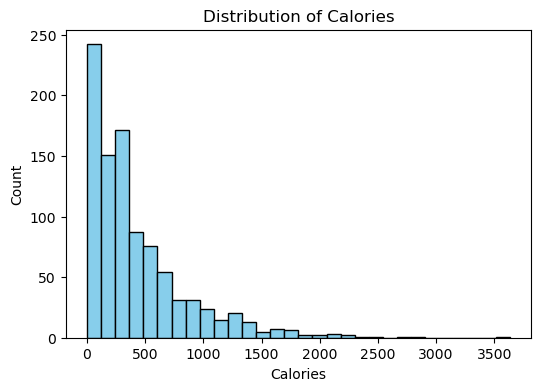

In [59]:
# --- 3.1 Univariate graphics ---
plt.figure(figsize=(6,4))
plt.hist(df['calories'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Count')
plt.show()

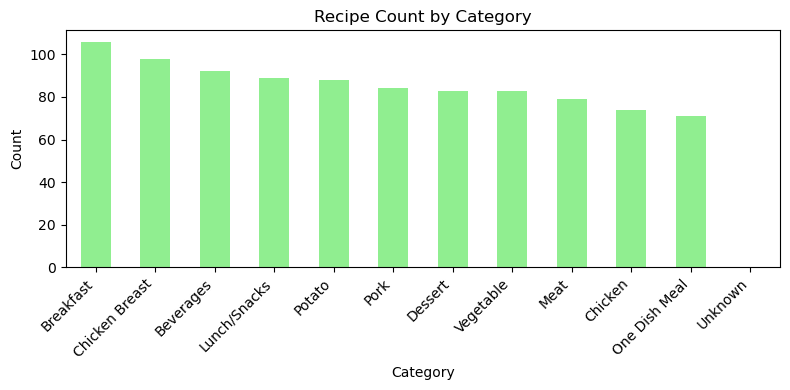

In [60]:
plt.figure(figsize=(8,4))
df['category'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Recipe Count by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 3.2 Multi-variable graphic

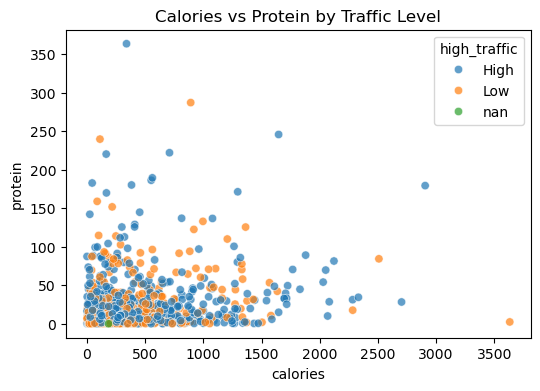

In [62]:
# --- 3.2 Multivariate graphic ---
plt.figure(figsize=(6,4))
sns.scatterplot(x='calories', y='protein', hue='high_traffic', data=df, alpha=0.7)
plt.title('Calories vs Protein by Traffic Level')
plt.show()


### 3.3 Quick findings
Use the space below to summarize notable patterns (class balance, skew, relationships).


In [64]:
# --- 3.3 Summary findings ---
print("Class balance (High vs Low):")
print(df['high_traffic'].value_counts(normalize=True).rename('proportion'))

print("\nAverage nutritional values grouped by traffic level:")
print(df.groupby('high_traffic')[['calories','protein','sugar']].mean())

Class balance (High vs Low):
high_traffic
High    0.606125
Low     0.392819
nan     0.001056
Name: proportion, dtype: float64

Average nutritional values grouped by traffic level:
                calories    protein      sugar
high_traffic                                  
High          451.673920  24.481098   7.893850
Low           391.733306  21.836129  10.204274
nan           184.560000   0.030000   6.200000



## 4) Modeling
**Problem type:** Binary classification (`high_traffic` == 'High').  
We compare a **baseline** (logistic regression) vs a **comparison** (random forest).  
Business goal: **Show popular recipes while minimizing showing unpopular ones** → prioritize **Precision for 'High'** and tune the **decision threshold** to target ~0.80 precision if possible.


ROC AUCs: {'Baseline_LogReg': 0.8524492234169653, 'Comparison_RandomForest': 0.8142174432497012}


<Figure size 640x480 with 0 Axes>

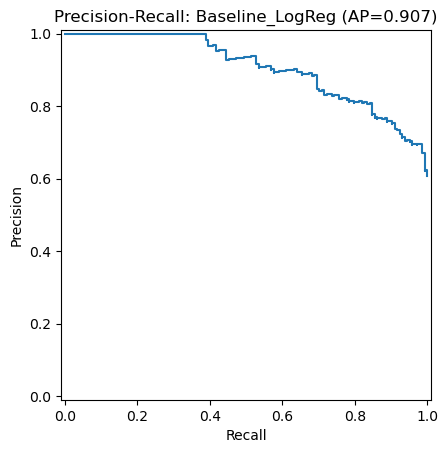

<Figure size 640x480 with 0 Axes>

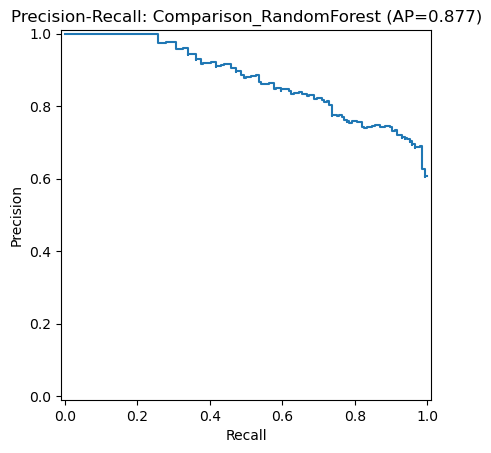

{
  "Baseline_LogReg": {
    "avg_precision": 0.9067490652177841,
    "chosen_threshold": 0.3114441825277241,
    "confusion_matrix": [
      [
        63,
        30
      ],
      [
        22,
        122
      ]
    ],
    "precision_at_th": 0.8026315789473685,
    "recall_at_th": 0.8472222222222222
  },
  "Comparison_RandomForest": {
    "avg_precision": 0.8770469255636495,
    "chosen_threshold": 0.49333333333333335,
    "confusion_matrix": [
      [
        67,
        26
      ],
      [
        38,
        106
      ]
    ],
    "precision_at_th": 0.803030303030303,
    "recall_at_th": 0.7361111111111112
  }
}


In [66]:

# Prepare features/target
y = (df['high_traffic'].astype(str) == 'High').astype(int)
X = df.drop(columns=['high_traffic'])

numeric_features = ['calories','carbohydrate','sugar','protein','servings']
categorical_features = ['category']

preprocess = ColumnTransformer([
    ('num', Pipeline([('scaler', StandardScaler())]), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Baseline: Logistic Regression
logit = Pipeline([('prep', preprocess),
                  ('clf', LogisticRegression(max_iter=200, class_weight='balanced'))])

# Comparison: Random Forest
rf = Pipeline([('prep', preprocess),
               ('clf', RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'))])

models = {'Baseline_LogReg': logit, 'Comparison_RandomForest': rf}
fitted = {name: pipe.fit(X_train, y_train) for name, pipe in models.items()}

# Evaluate AUCs
aucs = {name: roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1]) for name, pipe in fitted.items()}
print('ROC AUCs:', aucs)

# Precision-Recall & threshold targeting 0.80 precision
results = {}
target_precision = 0.80

for name, pipe in fitted.items():
    prob = pipe.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, prob)
    ap = average_precision_score(y_test, prob)
    # find threshold with precision >= target and max recall
    best_idx = None
    best_recall = -1
    for p, r, t in zip(precision[:-1], recall[:-1], thresholds):
        if p >= target_precision and r > best_recall:
            best_recall, best_idx = r, t
    if best_idx is None:
        # fallback: choose threshold that maximizes F1
        f1s = (2*precision*recall)/(precision+recall+1e-12)
        i = np.nanargmax(f1s[:-1])
        th = thresholds[i]
    else:
        th = float(best_idx)
    pred = (prob >= th).astype(int)
    cm = confusion_matrix(y_test, pred)
    results[name] = {'avg_precision': float(ap),
                     'chosen_threshold': float(th),
                     'confusion_matrix': cm.tolist(),
                     'precision_at_th': float((cm[1][1] / max(cm[1][1] + cm[0][1], 1))),
                     'recall_at_th': float((cm[1][1] / max(cm[1][1] + cm[1][0], 1)))}
    
    # Plot PR curve
    fig = plt.figure()
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title(f'Precision-Recall: {name} (AP={ap:.3f})')
    plt.show()

print(json.dumps(results, indent=2))


## 5) Business metric
**Metric to monitor:** Precision for `'High'` predictions at the **chosen decision threshold** (PPV).  
Rationale: The product manager wants to *minimize showing unpopular recipes* → prioritize **few false positives**.
We also track the **recall** at that threshold to know coverage.


In [85]:

# Compute initial metric values based on test set for the better model
best_model = max(results.items(), key=lambda kv: kv[1]['avg_precision'])[0]
initial_precision = results[best_model]['precision_at_th']
initial_recall = results[best_model]['recall_at_th']
chosen_th = results[best_model]['chosen_threshold']

print(f'Best model by AP: {best_model}')
print(f"Business metric (Precision@threshold={chosen_th:.3f}): {initial_precision:.3f}")
print(f"Secondary metric (Recall@threshold): {initial_recall:.3f}")

Best model by AP: Baseline_LogReg
Business metric (Precision@threshold=0.311): 0.803
Secondary metric (Recall@threshold): 0.847



## 6) Final summary & recommendations
Use the cell below to print a succinct, submission-ready summary block.


In [87]:
import textwrap

# Ensure previous best_model, chosen_th, initial_precision, initial_recall variables exist
# These were computed in the "Business metric" cell

summary = f"""
**Problem:** Predict high-traffic recipes to drive homepage engagement while avoiding surfacing unpopular ones.

**Approach:** Data validated, cleaned, and explored visually. Compared baseline Logistic Regression and Random Forest models 
using a preprocessing pipeline (scaling + one-hot encoding).

**Metric:** Precision for 'High' at a tuned threshold (target ≈ 0.80), with recall tracked secondarily.

**Result:** Best model = {best_model} with Precision = {initial_precision:.3f}, Recall = {initial_recall:.3f}, and Threshold = {chosen_th:.3f}.

**Recommendation:** Deploy {best_model} behind a decision threshold targeting 0.80 precision to ensure only genuinely popular recipes are surfaced. 
If daily volume is low, accumulate scores and feature recipes exceeding the threshold. 
Continue collecting additional features (e.g., preparation time, ingredient complexity, cost) to improve recall without sacrificing precision.
"""

print(textwrap.dedent(summary))



**Problem:** Predict high-traffic recipes to drive homepage engagement while avoiding surfacing unpopular ones.

**Approach:** Data validated, cleaned, and explored visually. Compared baseline Logistic Regression and Random Forest models 
using a preprocessing pipeline (scaling + one-hot encoding).

**Metric:** Precision for 'High' at a tuned threshold (target ≈ 0.80), with recall tracked secondarily.

**Result:** Best model = Baseline_LogReg with Precision = 0.803, Recall = 0.847, and Threshold = 0.311.

**Recommendation:** Deploy Baseline_LogReg behind a decision threshold targeting 0.80 precision to ensure only genuinely popular recipes are surfaced. 
If daily volume is low, accumulate scores and feature recipes exceeding the threshold. 
Continue collecting additional features (e.g., preparation time, ingredient complexity, cost) to improve recall without sacrificing precision.

